In [138]:
import pandas as pd
import numpy as np
import os

import requests

from datetime import date
from time import sleep 

import tqdm
import re 

from typing import Dict, List 

from random import randint

In [139]:
today=str(date.today())

# Add parameters

In [140]:
exp_file_name=("df_commercial_rent_"+today+".gzip")
exp_file_path=str(os.path.dirname(os.path.realpath("__file__")))
print(exp_file_path+"/"+exp_file_name)

/Users/vojtechkania/Library/CloudStorage/OneDrive-UniverzitaKarlova/Data Processing in Python/re_data_processing/df_commercial_rent_2022-12-24.gzip


In [141]:
category_main_cb = 4 # 1=byty, 2=domy, 3=pozemky, 4=komerční, 5=ostatní
category_type_cb = 2 # 1=prodej, 2=nájem, 3=dražba
category_sub_cb = [] # 34=garáže, 52=garážové stání
locality_region_id = [10, 11] #10=Praha, 11=Středočeský kraj, 5: Liberecký kraj

# Code 

In [142]:
category_sub_cb_string = '%7C'.join(str(v) for v in category_sub_cb)
print(category_sub_cb_string)

locality_region_id_string = '%7C'.join(str(v) for v in locality_region_id)
print(locality_region_id_string)


10%7C11


In [143]:
#https://1.im.cz/seznam/blog/articles/import.pdf
category_main_cb_dict={1:"byty", 2:"domy", 3:"pozemky", 4:"komerční", 5:"ostatní"}
category_main_cb_dict=pd.DataFrame.from_dict(category_main_cb_dict, orient="index", columns=["category_main_cb"])
print(category_main_cb_dict)

category_sub_cb_dict={
    2:"1+kk", 
    3:"1+1", 
    4:"2+kk", 
    5:"2+2", 
    6:"2+kk",
    34:"garáž",
    52:"garážové stání"}
category_sub_cb_dict=pd.DataFrame.from_dict(category_sub_cb_dict, orient="index", columns=["category_sub_cb"])
print(category_sub_cb_dict)

category_type_cb_dict={1:"prodej", 2:"nájem", 3:"dražba"}
category_type_cb_dict=pd.DataFrame.from_dict(category_type_cb_dict, orient="index", columns=["category_type_cb"])
print(category_type_cb_dict)

locality_region_id_dict={10:"Praha", 11:"Středočeský kraj", 5:"Liberecký kraj"}
locality_region_id_dict=pd.DataFrame.from_dict(locality_region_id_dict, orient="index", columns=["locality_region_id"])
print(locality_region_id_dict)

  category_main_cb
1             byty
2             domy
3          pozemky
4         komerční
5          ostatní
   category_sub_cb
2             1+kk
3              1+1
4             2+kk
5              2+2
6             2+kk
34           garáž
52  garážové stání
  category_type_cb
1           prodej
2            nájem
3           dražba
   locality_region_id
10              Praha
11   Středočeský kraj
5      Liberecký kraj


In [144]:
collector={}
i=0
run=True

while run==True:
    
    if len(category_sub_cb)>0:
        base_url = 'https://www.sreality.cz/api/cs/v2/estates?category_main_cb={}&category_sub_cb={}category_type_cb={}&locality_region_id={}&per_page60&page={}'.format(category_main_cb, category_sub_cb_string, category_type_cb, locality_region_id_string, i)
    else:
        base_url = 'https://www.sreality.cz/api/cs/v2/estates?category_main_cb={}&category_type_cb={}&locality_region_id={}&per_page60&page={}'.format(category_main_cb, category_type_cb, locality_region_id_string, i)
    
    r = requests.get(base_url)
    print("starting sleep")
    sleep(randint(1,3))

    if r.status_code==404:
        break
    elif r.status_code==200:
        r_dict=r.json()

        if len(r_dict["_embedded"]["estates"]) == 0:
            print(f"Page {i+1} is blank.")
            break

        collector[i]=r_dict
        
        print(f"Page {i+1} was scraped.")

        i=i+1
        j=0

    else:
        if  j==3:
            print(f"Code {r.status_code} was returned.")
            break
        else:
            j=j+1

starting sleep
Page 1 was scraped.
starting sleep
Page 2 was scraped.
starting sleep
Page 3 was scraped.
starting sleep
Page 4 was scraped.
starting sleep
Page 5 was scraped.
starting sleep
Page 6 was scraped.
starting sleep
Page 7 was scraped.
starting sleep
Page 8 was scraped.
starting sleep
Page 9 was scraped.
starting sleep
Page 10 was scraped.
starting sleep
Page 11 was scraped.
starting sleep
Page 12 was scraped.
starting sleep


In [ ]:
def get_gps_lat_lon(estate_raw: Dict):
    gps_ = estate_raw['gps']
    return gps_['lat'], gps_['lon']

# more robust implementation using regex - https://docs.python.org/3/library/re.html
def get_area_from_name(name: str):
    """(\d*) matches any decimal digits (repeated after each other"""
    name_ = name.split()
    return int(''.join(re.findall('(\d*)', ''.join(name_))))

In [ ]:
collector[0];

In [ ]:
# slow helper functions (use itertools.chains for speedup)
def flatten_list(l:List):
    return [item for sublist in l for item in sublist]

def get_distinct_nearby_objects(estates_individual_raw: Dict):
    lists_of_nearby_objects = [e['labelsAll'][1] for e in estates_individual_raw.values()]
    return list(set(flatten_list(lists_of_nearby_objects)))

def get_distinct_estate_attributes(estates_individual_raw: Dict):
    lists_of_estates_attributes = [e['labelsAll'][0] for e in estates_individual_raw.values()]
    return list(set(flatten_list(lists_of_estates_attributes)))

In [ ]:
def get_company_details(estate_raw: Dict):
    try:
            company_id = estate_raw["_embedded"]["company"]["id"]
            company_name = estate_raw["_embedded"]["company"]["name"]
    except (KeyError):
            company_id = np.nan
            company_name = np.nan

    return company_id, company_name

In [ ]:
raw_attributes_to_collect = ['locality', 'price', 'name', 'gps','hash_id','labelsAll','exclusively_at_rk']

estates_individual_raw = {}
estates_individual = {}

for page, r in collector.items():
    for estate in r['_embedded']['estates']: 

        estate_raw = {k:v for k,v in estate.items() if k in raw_attributes_to_collect}

        estate_relevant = pd.Series(dtype="object")

        estate_relevant['price'] = int(estate['price'])
        estate_relevant['price_czk'] = int(estate['price_czk']["value_raw"])
        estate_relevant['area'] = get_area_from_name(estate['name'])

        lat, lon = get_gps_lat_lon(estate)
        estate_relevant.loc['lat'] = lat
        estate_relevant.loc['lon'] = lon
        estate_relevant['locality'] = estate['locality']
        estate_relevant['type'] = estate['type']
        estate_relevant['category'] = estate['category']
        estate_relevant['is_auction'] = estate['is_auction']
        estate_relevant['exclusively_at_rk'] = estate['exclusively_at_rk']

        estate_relevant['category_main_cb'] = estate["seo"]["category_main_cb"]
        estate_relevant['category_sub_cb'] = estate["seo"]["category_sub_cb"]
        estate_relevant['category_type_cb'] = estate["seo"]["category_type_cb"]

        company_id, company_name = get_company_details(estate)
        estate_relevant['company_id'] = company_id
        estate_relevant['company_name'] = company_name
        
        estates_individual_raw[estate['hash_id']] = estate_raw
        estates_individual[estate['hash_id']] = estate_relevant

In [ ]:
estate

{'labelsReleased': [[], []],
 'has_panorama': 0,
 'labels': [],
 'is_auction': False,
 'labelsAll': [[''],
  ['playground',
   'theater',
   'vet',
   'tavern',
   'small_shop',
   'candy_shop',
   'movies',
   'natural_attraction',
   'medic',
   'post_office',
   'school',
   'train',
   'atm',
   'sports',
   'tram',
   'bus_public_transport',
   'kindergarten',
   'shop',
   'metro',
   'restaurant',
   'drugstore']],
 'seo': {'category_main_cb': 5,
  'category_sub_cb': 34,
  'category_type_cb': 2,
  'locality': 'praha-brevnov-belohorska'},
 'exclusively_at_rk': 0,
 'category': 5,
 'has_floor_plan': 0,
 '_embedded': {'favourite': {'is_favourite': False,
   '_links': {'self': {'profile': '/favourite/doc',
     'href': '/cs/v2/favourite/619855452',
     'title': 'Oblibene inzeraty'}}},
  'note': {'note': '',
   '_links': {'self': {'profile': '/note/doc',
     'href': '/cs/v2/note/619855452',
     'title': 'Poznamky inzeratu'}},
   'has_note': False},
  'company': {'url': 'Blue-House-

In [ ]:
get_distinct_nearby_objects(estates_individual_raw);
get_distinct_estate_attributes(estates_individual_raw);

In [ ]:
estates_individual;

In [ ]:
df = pd.concat(estates_individual).unstack()

In [ ]:
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'hash_id'})
df.head()

,hash_id,price,price_czk,area,lat,lon,locality,type,category,is_auction,exclusively_at_rk,category_main_cb,category_sub_cb,category_type_cb,company_id,company_name
0,2670483276,1225000.0,1225000.0,21.0,50.035338,14.458362,Praha 4 - Michle,1,5,False,0,5,52,1,43314,Duna House
1,2495821644,1758000.0,1758000.0,21.0,50.057895,14.518219,Praha 10 - Strašnice,1,5,False,1,5,34,1,NaN,NaN
2,156955724,2000.0,2000.0,13.0,50.064158,14.500559,Praha 10 - Strašnice,2,5,False,1,5,34,2,NaN,NaN
3,2362082380,558000.0,558000.0,17.0,49.997397,14.413837,Praha 4 - Modřany,1,5,False,0,5,34,1,NaN,NaN
4,377640780,395000.0,395000.0,16.0,50.100554,14.498755,Praha 9 - Prosek,1,5,False,1,5,52,1,14367,Home Real Estate


In [ ]:
df.shape

(519, 15)

### Saving data

In [ ]:
import os

In [ ]:
df.to_parquet(exp_file_path+"/"+exp_file_name) 

### Visualisation

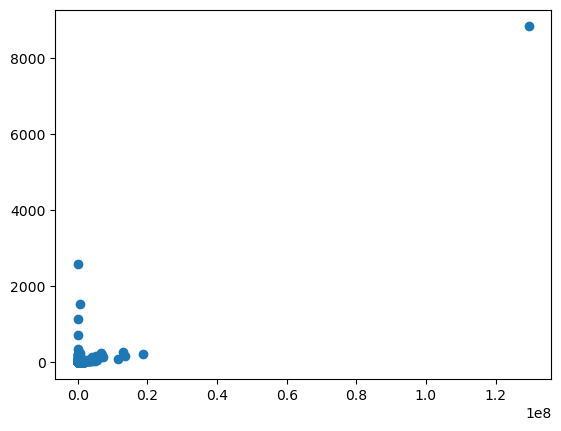

In [ ]:
import matplotlib.pyplot as plt 
df_filtered=df.loc[df['area'] < 100000] 
plt.scatter(df_filtered['price'],df_filtered['area'])